In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits import mplot3d
import time
import warnings
warnings.filterwarnings('ignore')
import importlib #importlib.reload(my_module)
import functions
importlib.reload(functions)
from functions import *

In [2]:
from netCDF4 import Dataset
ncfile = Dataset("data/air.202010.nc")
air = np.squeeze(ncfile.variables['air'])
ncfile.close()
air = air[:,16,:252,1:337]

In [3]:
A = air
del air
N = A.shape

In [4]:
N

(248, 252, 336)

In [5]:
# matrix unfoldings
A0 = A.reshape(N[0],N[1]*N[2]) # 0 1 2
tmp = np.moveaxis(A,0,2) # 1 2 0
A1 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])
tmp = np.moveaxis(A,2,0) # 2 0 1
A2 = tmp.reshape(tmp.shape[0],tmp.shape[1]*tmp.shape[2])

In [6]:
scree = HOSVD_rank(A)

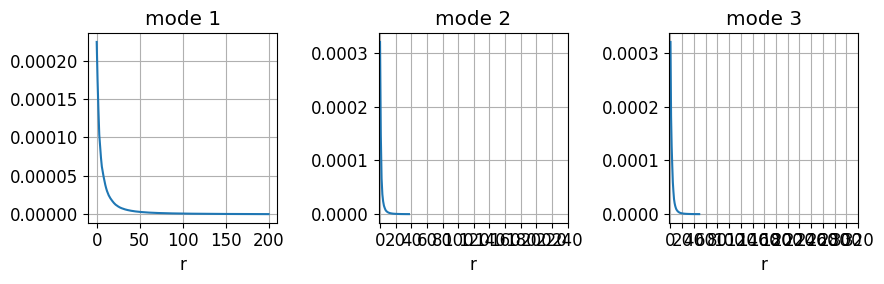

In [7]:
plt.rcParams.update({'font.size': 12})
fig,ax = plt.subplots(1,3,figsize=(9,3))
ax[0].plot(scree[0])
ax[0].set_title('mode 1')
ax[0].set_xlabel('r')
ax[0].set_xticks(np.arange(0, N[0], 50))
ax[0].grid()

ax[1].plot(scree[1])
ax[1].set_title('mode 2')
ax[1].set_xlabel('r')
ax[1].set_xticks(np.arange(0, N[1], 20))
ax[1].grid()

ax[2].plot(scree[2])
ax[2].set_title('mode 3')
ax[2].set_xlabel('r')
ax[2].set_xticks(np.arange(0, N[2], 20))
ax[2].grid()
plt.tight_layout()
#plt.savefig('plots/cardiac_screes.png',dpi=300)
plt.show()

In [9]:
r = np.array([50,10,20])
errs = []
times = []
for i in range(100):
    print(f'{i}/100',end='\r')
    RP_HOSVD_err, RP_HOSVD_time = RP_HOSVD(A,A0,A1,A2,r)
    RP_STHOSVD_err, RP_STHOSVD_time = RP_STHOSVD(A,A0,A1,A2,r)
    R_PET_err, R_PET_time = R_PET(A,A0,A1,A2,r)
    R_ST_err, R_ST_time = R_ST(A,A0,A1,A2,r)
    R_HOID_err, R_HOID_time = R_HOID(A,A0,A1,A2,r)
    RP_HOOI_err, RP_HOOI_time = RP_HOOI(A,r,tol=10)
    R_SCTT_err, R_SCTT_time = R_SCTT(A,r,0.5)
    _, R_SCT_err, R_SCT_time = Random_SketchyCoreTucker(A,r,300)
    _, P_SCT_err, m, P_SCT_time = pgSketchyCoreTucker(A,r,10,10,300)
    errs.append([RP_HOSVD_err,RP_STHOSVD_err,R_PET_err,R_ST_err,R_HOID_err,RP_HOOI_err,R_SCTT_err,R_SCT_err,P_SCT_err])
    times.append([RP_HOSVD_time,RP_STHOSVD_time,R_PET_time,R_ST_time,R_HOID_time,RP_HOOI_time,R_SCTT_time,R_SCT_time,P_SCT_time])
errs = np.array(errs)
times = np.array(times)

In [10]:
print(np.mean(errs,axis=0))
print(np.mean(times,axis=0))

[3.35424574e-05 8.15010420e-05 3.89847272e+00 5.11592217e-04
 2.15842191e-05 2.34023810e-05 2.08745717e-01 2.37894874e-01
 4.93822889e-05]
[1.33559828 3.61674539 2.70094459 0.21717266 2.90263324 2.62195518
 7.09192135 0.90007726 1.662275  ]


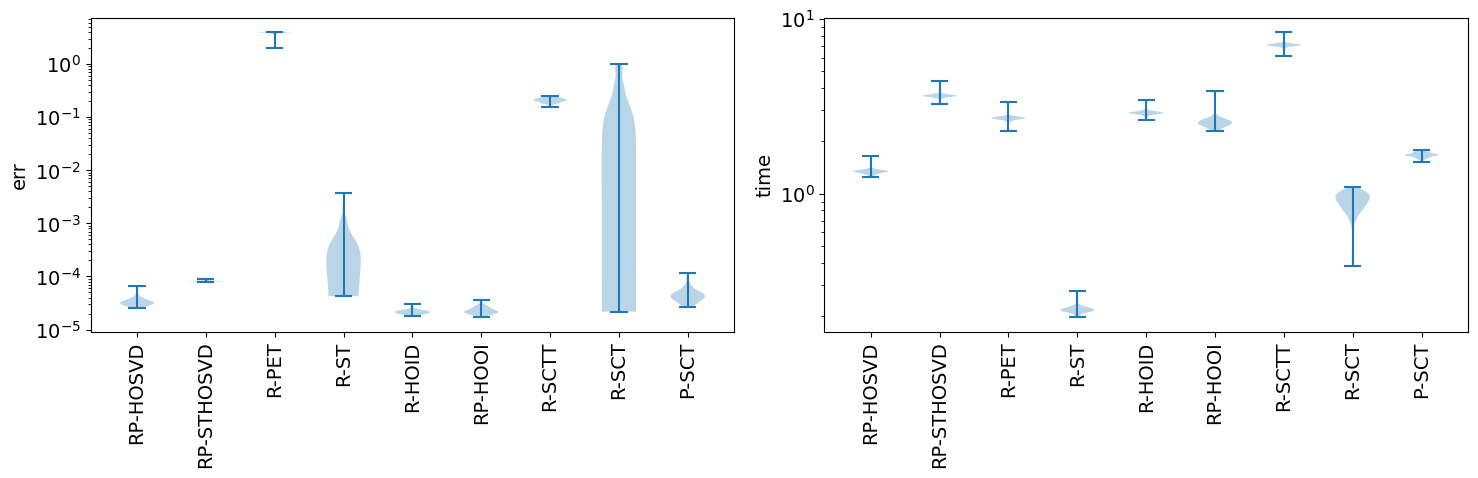

In [14]:
plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1,2,figsize=[15,5])
ax[0].violinplot(errs,vert=True)
ax[0].set_yscale('log')
ax[0].set_ylabel('err')
ax[0].set_xticks(range(1,10))
ax[0].set_xticklabels(['RP-HOSVD','RP-STHOSVD','R-PET','R-ST','R-HOID','RP-HOOI','R-SCTT','R-SCT','P-SCT'],rotation=90)
ax[1].violinplot(times,vert=True)
ax[1].set_yscale('log')
ax[1].set_ylabel('time')
ax[1].set_xticks(range(1,10))
ax[1].set_xticklabels(['RP-HOSVD','RP-STHOSVD','R-PET','R-ST','R-HOID','RP-HOOI','R-SCTT','R-SCT','P-SCT'],rotation=90)
plt.tight_layout()
plt.savefig('plots/air_error_ACML.png',dpi=300)
plt.show()

# Learning Curve

In [25]:
logPS_0, logPS_1, logPS_2 = pgskt_log(A,r,10,10,500)
err_logPS = lc(N,A,A0,A1,A2,r,logPS_0,logPS_1,logPS_2)

In [26]:
logRS_0, logRS_1, logRS_2 = rdskt_log(A,r,10,10,500)
err_logRS = lc(N,A,A0,A1,A2,r,logRS_0,logRS_1,logRS_2)

In [27]:
nf_PS = [len(i)+len(j)+len(k) for i,j,k in zip(logPS_0,logPS_1,logPS_2)]
nf_RS = [len(i)+len(j)+len(k) for i,j,k in zip(logRS_0,logRS_1,logRS_2)]

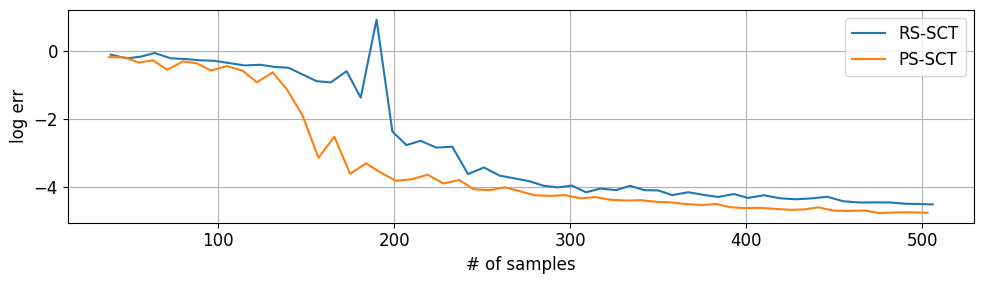

In [28]:
plt.rcParams.update({'font.size': 12})
plt.figure(figsize=[10,3])
plt.plot(nf_RS[1:], np.log10(err_logRS)[1:],label='RS-SCT')
plt.plot(nf_PS[1:], np.log10(err_logPS)[1:],label='PS-SCT')
plt.ylabel('log err')
plt.xlabel('# of samples')
plt.legend()
plt.tight_layout()
plt.grid()
#plt.savefig('plots/air_lc_permutation.png',dpi=300)
plt.show()

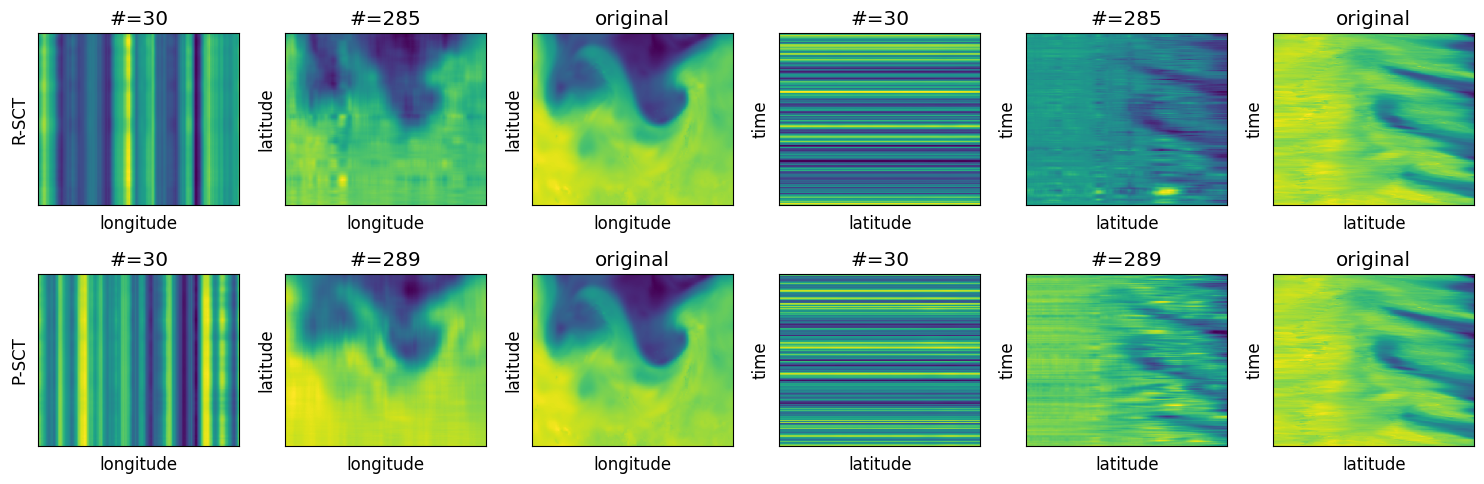

In [29]:
plt.rcParams.update({'font.size': 12})
f, ax = plt.subplots(2,6,figsize=[15,5])

ax[0,0].pcolormesh(Ahat(N,A,A0,A1,A2,r,logRS_0[0],logRS_1[0],logRS_2[0])[0,:,:])
ax[0,1].pcolormesh(Ahat(N,A,A0,A1,A2,r,logRS_0[30],logRS_1[30],logRS_2[30])[0,:,:])
ax[0,0].set_title('#=' + str(nf_RS[0]))
ax[0,1].set_title('#=' + str(nf_RS[30]))

ax[1,0].pcolormesh(Ahat(N,A,A0,A1,A2,r,logPS_0[0],logPS_1[0],logPS_2[0])[0,:,:])
ax[1,1].pcolormesh(Ahat(N,A,A0,A1,A2,r,logPS_0[30],logPS_1[30],logPS_2[30])[0,:,:])
ax[1,0].set_title('#=' + str(nf_PS[0]))
ax[1,1].set_title('#=' + str(nf_PS[30]))

ax[0,2].pcolormesh(A[0,:,:])
ax[1,2].pcolormesh(A[0,:,:])
ax[0,2].set_title('original')
ax[1,2].set_title('original')

ax[0,3].pcolormesh(Ahat(N,A,A0,A1,A2,r,logRS_0[0],logRS_1[0],logRS_2[0])[:,:,0])
ax[0,4].pcolormesh(Ahat(N,A,A0,A1,A2,r,logRS_0[30],logRS_1[30],logRS_2[30])[:,:,0])
ax[0,3].set_title('#=' + str(nf_RS[0]))
ax[0,4].set_title('#=' + str(nf_RS[30]))

ax[1,3].pcolormesh(Ahat(N,A,A0,A1,A2,r,logPS_0[0],logPS_1[0],logPS_2[0])[:,:,0])
ax[1,4].pcolormesh(Ahat(N,A,A0,A1,A2,r,logPS_0[30],logPS_1[30],logPS_2[30])[:,:,0])
ax[1,3].set_title('#=' + str(nf_PS[0]))
ax[1,4].set_title('#=' + str(nf_PS[30]))

ax[0,5].pcolormesh(A[:,:,0])
ax[1,5].pcolormesh(A[:,:,0])
ax[0,5].set_title('original')
ax[1,5].set_title('original')

for i, axis in enumerate(ax.ravel()):
    axis.set_xticks([])
    axis.set_yticks([])
    if i%6 < 3:
        axis.set_xlabel('longitude')
        axis.set_ylabel('latitude')
    else:
        axis.set_xlabel('latitude')
        axis.set_ylabel('time')

ax[0,0].set_ylabel('R-SCT')
ax[1,0].set_ylabel('P-SCT')

plt.tight_layout()
plt.savefig('plots/air_Ar_permutation_ACML.png',dpi=300)
plt.show()

# Thumbnail

In [17]:
r = 10
p = 0.5
q = 0.5
Q, Cr, P, rows, cols = SCSVD(A[0,:,:],r,p,q)

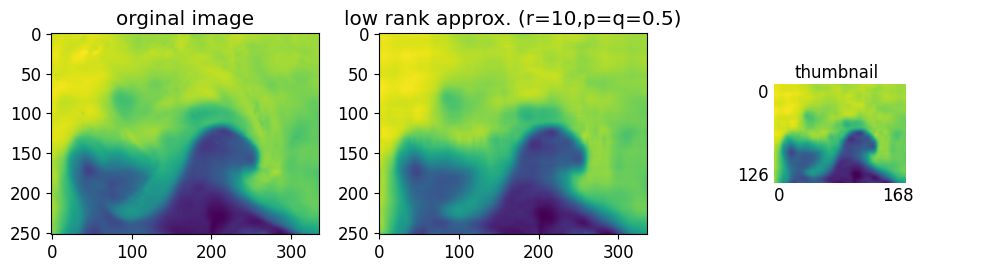

In [43]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,3,figsize=[10,5])
ax[0].imshow(A[0,:,:])
ax[0].set_aspect('equal')
ax[0].set_title('orginal image')

Ahat = Q.dot(Cr).dot(P)
ax[1].imshow(Ahat)
ax[1].set_aspect('equal')
ax[1].set_title(f'low rank approx. (r={r},p=q={p})')

thumbnail = np.full_like(A[0,:,:],np.nan)
rows = np.arange(0,N[1],2)
cols = np.arange(0,N[2],2)
origin = [int(N[1]/2 - len(rows)/2),int(N[2]/2 - len(cols)/2)]
lr = origin[0]
ur = lr + len(rows)
lc = origin[1]
uc = lc + len(cols)
thumbnail[lr:ur,lc:uc] = Q[rows,:].dot(Cr).dot(P[:,cols])
ax[2].imshow(thumbnail)
ax[2].set_aspect('equal')
ax[2].axis('off')

ax[2].annotate('thumbnail',(110,55),fontsize=12)
ax[2].annotate('0',(65,80))
ax[2].annotate(f'{len(rows)}',(38,185))
ax[2].annotate('0',(85,210))
ax[2].annotate(f'{len(cols)}',(220,210))
plt.tight_layout()
plt.savefig('plots/air_thumbnail_ACML.png',dpi=300)
plt.show()